In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import random
import keras

import matplotlib.pyplot as plt
import seaborn as sns

from random import shuffle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.utils import to_categorical
from tensorflow.keras import models, layers
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten

from tensorflow.keras.datasets import cifar10

2022-11-21 12:31:40.663773: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
50000 train samples
10000 test samples


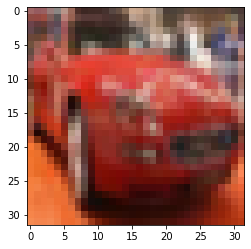

In [3]:
plt.imshow(x_train[5]) 

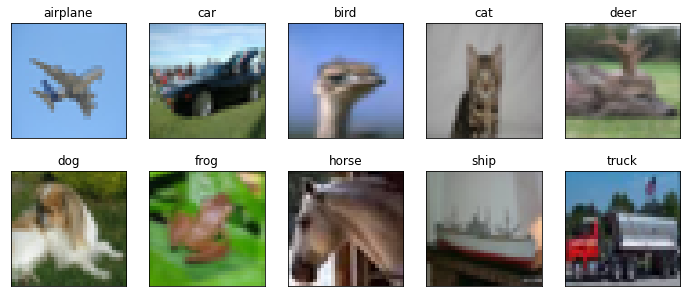

In [7]:
class_names = ['airplane','car','bird','cat','deer',
               'dog','frog','horse','ship','truck']

fig = plt.figure(figsize=(12, 5))
for i in range(10):
    ax = fig.add_subplot(2, 5, 1 + i, xticks=[], yticks=[])
    idx = np.where(y_train[:]==i)[0]
    features_idx = x_train[idx,::]
    img_num = np.random.randint(features_idx.shape[0])
    im = (features_idx[img_num,::])
    ax.set_title(class_names[i])
    plt.imshow(im)
plt.show() 

In [8]:
# Split Data for Train, Test, and Validation

def prep_dataset(X,y):
    X_prep = X.astype('float32')/255
    y_prep = to_categorical(np.array(y))
    return (X_prep, y_prep)

In [9]:
X_ts, X_val, Y_ts, Y_val = train_test_split(x_test,y_test, test_size=0.5, stratify=y_test,random_state=42)

X_tr, Y_tr = prep_dataset(x_train,y_train)
X_val, Y_val = prep_dataset(X_val,Y_val)
X_ts, _ = prep_dataset(X_ts,Y_ts)

In [10]:
'''
# Fully Connected Layer

model = models.Sequential()
#Input + Conv 1 + ReLU + Max Pooling
model.add(Conv2D(32,(5,5),activation='relu',padding='same',input_shape=X_tr.shape[1:]))
model.add(layers.MaxPool2D(strides=4))
model.add(layers.BatchNormalization())

# Conv 2 + ReLU + Max Pooling
model.add(Conv2D(64,(5,5),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 3 + ReLU + Max Pooling
model.add(Conv2D(128,(3,3),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Conv 4 + ReLU + Max Pooling
model.add(Conv2D(256,(3,3),dilation_rate=(2,2),padding='same',activation='relu'))
model.add(layers.MaxPool2D(strides=2))
model.add(layers.BatchNormalization())

# Fully Connected + ReLU
model.add(layers.Flatten())
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(100, activation='relu'))

#Output
model.add(layers.Dense(2, activation='softmax'))
model.summary()
'''

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 8, 8, 32)         0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 8, 8, 32)         128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 64)         0         
 2D)                                                             
                                                        

2022-11-21 12:34:42.693606: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 flatten (Flatten)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 300)               77100     
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 2)                 202       
                                                                 
Total params: 532,042
Trainable params: 531,082
Non-trainable params: 960
_________________________________________________________________


In [13]:
# Fully Connected Layer

model = Sequential()
# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(32, (3, 3), padding='same',input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# CONV => RELU => CONV => RELU => POOL => DROPOUT
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# FLATTERN => DENSE => RELU => DROPOUT
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
# a softmax classifier
model.add(Dense(10))
model.add(Activation('softmax'))

model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)        0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                      

In [15]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy',mode='max',patience=3,verbose=1)

history= model.fit(X_tr,Y_tr,
                   epochs=20,
                   batch_size=50,
                   validation_data=(X_val,Y_val),
                   callbacks=[es])

Epoch 1/20
1000/1000 [==============================] - 90s 90ms/step - loss: 0.5605 - accuracy: 0.8025 - val_loss: 0.6540 - val_accuracy: 0.7802
Epoch 2/20
1000/1000 [==============================] - 89s 89ms/step - loss: 0.5404 - accuracy: 0.8100 - val_loss: 0.6428 - val_accuracy: 0.7826
Epoch 3/20
1000/1000 [==============================] - 90s 90ms/step - loss: 0.5297 - accuracy: 0.8131 - val_loss: 0.6722 - val_accuracy: 0.7838
Epoch 4/20
1000/1000 [==============================] - 90s 90ms/step - loss: 0.5175 - accuracy: 0.8157 - val_loss: 0.6837 - val_accuracy: 0.7686
Epoch 5/20
1000/1000 [==============================] - 95s 95ms/step - loss: 0.5019 - accuracy: 0.8221 - val_loss: 0.6510 - val_accuracy: 0.7870
Epoch 6/20
1000/1000 [==============================] - 91s 91ms/step - loss: 0.4984 - accuracy: 0.8246 - val_loss: 0.6583 - val_accuracy: 0.7770
Epoch 7/20
1000/1000 [==============================] - 93s 93ms/step - loss: 0.4862 - accuracy: 0.8283 - val_loss: 0.6501 -

In [16]:
pd.DataFrame(model.history.history)

,loss,accuracy,val_loss,val_accuracy
0,0.560461,0.80250,0.653974,0.7802
1,0.540414,0.80998,0.642829,0.7826
2,0.529708,0.81306,0.672153,0.7838
3,0.517486,0.81566,0.683694,0.7686
4,0.501855,0.82212,0.651036,0.7870
5,0.498355,0.82464,0.658271,0.7770
6,0.486199,0.82828,0.650146,0.7852
7,0.478857,0.82970,0.654405,0.7822


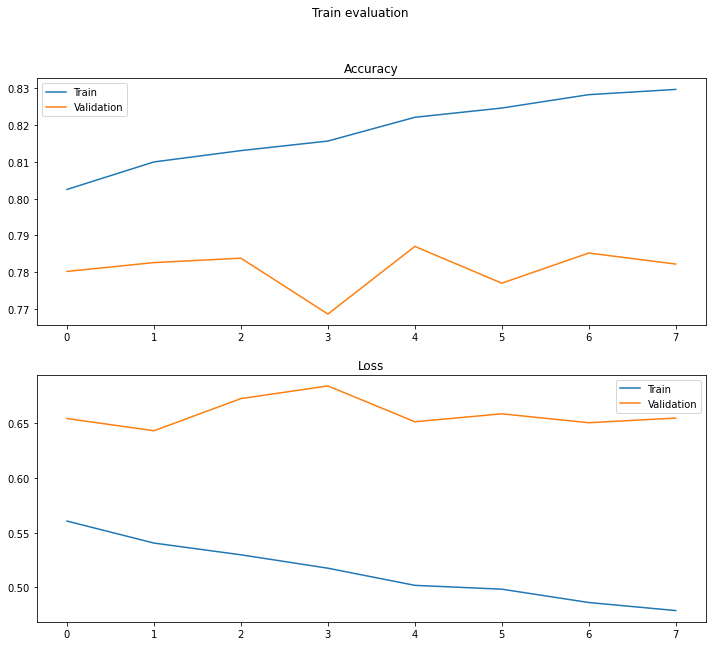

In [17]:
# Evaluation

fig, ax=plt.subplots(2,1,figsize=(12,10))
fig.suptitle('Train evaluation')

sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['accuracy'])
sns.lineplot(ax= ax[0],x=np.arange(0,len(history.history['accuracy'])),y=history.history['val_accuracy'])
ax[0].legend(['Train','Validation'])
ax[0].set_title('Accuracy')

sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['loss'])
sns.lineplot(ax= ax[1],x=np.arange(0,len(history.history['loss'])),y=history.history['val_loss'])
ax[1].legend(['Train','Validation'])
ax[1].set_title('Loss')
plt.show()

157/157 [==============================] - 2s 13ms/step


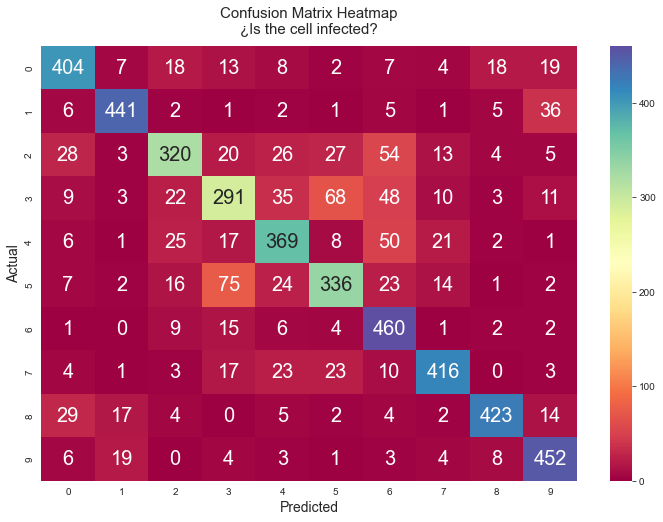

*Acuracy achieved: 78.24%
*Accuracy by model was: 82.97%
*Accuracy by validation was: 78.22%


In [19]:
Y_pred = model.predict(X_ts)
Y_pred = np.argmax(Y_pred, axis=1)
conf_mat = confusion_matrix(Y_ts,Y_pred)
sns.set_style(style='white')
plt.figure(figsize=(12,8))
heatmap = sns.heatmap(conf_mat,vmin=np.min(conf_mat.all()), 
                      vmax=np.max(conf_mat), annot=True,fmt='d', 
                      annot_kws={"fontsize":20},cmap='Spectral')
heatmap.set_title('Confusion Matrix Heatmap\n¿Is the cell infected?', fontdict={'fontsize':15}, pad=12)
heatmap.set_xlabel('Predicted',fontdict={'fontsize':14})
heatmap.set_ylabel('Actual',fontdict={'fontsize':14})
plt.show()
print('*Acuracy achieved: {:.2f}%\n*Accuracy by model was: {:.2f}%\n*Accuracy by validation was: {:.2f}%'.
       format(accuracy_score(Y_ts,Y_pred)*100,
              (history.history['accuracy'][-1])*100,
              (history.history['val_accuracy'][-1])*100)
     )